#Imports & Settings

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models


from PIL import Image, ImageDraw, ImageFont
import numpy as np

torch.backends.cudnn.enabled = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2
%matplotlib inline
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

In [2]:
def data_to_image(data):
    data_images = []
    font = ImageFont.truetype('/content/drive/MyDrive/Dacon/JjzoJe3v0Y1GrvtqZaC2DofdiS8.ttf',size=50)
    for dat in data:
        background = np.array([[0 for _ in range(255)] for _ in range(255)], dtype='uint8')
        image = Image.fromarray(background)
        draw = ImageDraw.Draw(image)
        draw.text((32, 32), str(dat[0]), fill='white', font=font)
        draw.text((32, 160), str(dat[1]), fill='white', font=font)
        draw.text((160, 32), str(dat[2]), fill='white', font=font)
        draw.text((160, 160), str(dat[3]), fill='white', font=font)
        rgb = [np.array(image, dtype='uint8') for _ in range(3)]
        data_images.append(rgb)
    return np.array(data_images) / 255

#Data Preparation

(120, 4) (30, 4) (120,) (30,)
(120, 3, 255, 255)
(30, 3, 255, 255)


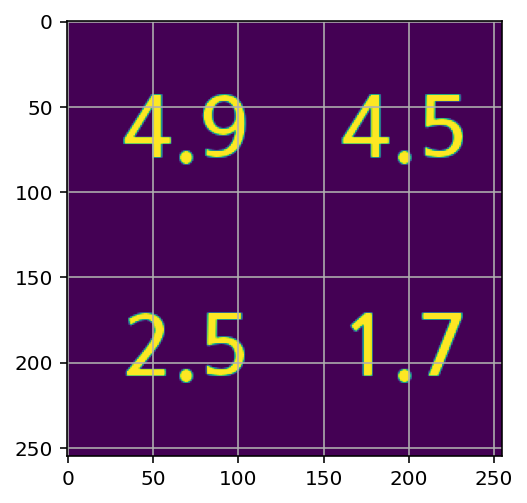

In [3]:
iris_data = load_iris()

X_train, X_val, y_train, y_val = train_test_split(iris_data.data, iris_data.target, stratify=iris_data.target, test_size=0.2, random_state=0)
print(X_train.shape,X_val.shape,y_train.shape, y_val.shape)
train_images = data_to_image(X_train)
val_images = data_to_image(X_val)

print(train_images.shape)
print(val_images.shape)
plt.grid()
plt.imshow(train_images[119][0, :, :])

In [4]:
X_train = torch.from_numpy(train_images).float()
y_train = torch.from_numpy(y_train).long()
X_val = torch.from_numpy(val_images).float()
y_val = torch.from_numpy(y_val).long()

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

dataloaders = {'train': DataLoader(train_dataset, batch_size=16, shuffle=True),
              'val': DataLoader(val_dataset)}

dataset_sizes = {'train': len(X_train),
                'val': len(X_val)}

In [5]:
model = models.resnet18(pretrained=True).to(device)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
import copy
import time

import torch

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, device, epochs=20):
    start = time.time()
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(epochs):
        print("EPOCH {} / {}: ".format(epoch+1, epochs))
        print("-" * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            batch_loss = 0.0
            batch_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase =='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                batch_loss += loss.item() * inputs.size(0)
                batch_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = batch_loss / dataset_sizes[phase]
        epoch_acc = batch_corrects.double() / dataset_sizes[phase]
        
        print("{} Loss: {:.4f} Acc: {: .4f}".format(phase, epoch_loss, epoch_acc))
        
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_weights = copy.deepcopy(model.state_dict())
            
    end = time.time()
    elapsed_time = end - start
    print("Training COMPLETED: {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("BEST VALIDATION ACCURACY: {:4f}".format(best_acc))
    
    model.load_state_dict(best_model_weights)
    return model

In [7]:
best_model = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, device, epochs=10)

EPOCH 1 / 10: 
----------
val Loss: 0.8734 Acc:  0.7000
EPOCH 2 / 10: 
----------
val Loss: 0.2542 Acc:  0.9333
EPOCH 3 / 10: 
----------
val Loss: 0.1361 Acc:  0.9667
EPOCH 4 / 10: 
----------
val Loss: 0.6440 Acc:  0.8667
EPOCH 5 / 10: 
----------
val Loss: 0.7248 Acc:  0.8333
EPOCH 6 / 10: 
----------
val Loss: 0.7307 Acc:  0.8333
EPOCH 7 / 10: 
----------
val Loss: 0.3255 Acc:  0.9000
EPOCH 8 / 10: 
----------
val Loss: 0.2863 Acc:  0.9333
EPOCH 9 / 10: 
----------
val Loss: 0.0737 Acc:  0.9667
EPOCH 10 / 10: 
----------
val Loss: 7.5583 Acc:  0.3667
Training COMPLETED: 5m 15s
BEST VALIDATION ACCURACY: 0.966667
